# LCA of Germany's grid expansion


In [2]:
import bw2data as bd

In [3]:
bd.projects.set_current("bw25_plca_grid_expansion")

In [4]:
method = (
    "EF v3.1 no LT",
    "climate change no LT",
    "global warming potential (GWP100) no LT",
)

We do quite a few calculations here. To save some time, e.g., if only interested in the plots, set the "recalculate" variable to False.


In [5]:
recalculate = False

## GWI of static vs prospective expansion (Figure 4)


In [35]:
static_expansion_nodes = sorted([node for node in bd.Database("grid_expansion_static")])
prospective_expansion_nodes_base = sorted(
    [
        node
        for node in bd.Database("grid_expansion_prospective")
        if "Base" in node["name"]
    ]
)
prospective_expansion_nodes_rcp26 = sorted(
    [
        node
        for node in bd.Database("grid_expansion_prospective")
        if "RCP26" in node["name"]
    ]
)
prospective_expansion_nodes_rcp19 = sorted(
    [
        node
        for node in bd.Database("grid_expansion_prospective")
        if "RCP19" in node["name"]
    ]
)
prospective_expansion_nodes = (
    prospective_expansion_nodes_base
    + prospective_expansion_nodes_rcp26
    + prospective_expansion_nodes_rcp19
)

Calculating the LCA results for the static and prospective cases:


In [7]:
import bw2calc as bc
import json

if recalculate:
    # static expansion
    results_components = {}
    lca = bc.LCA(demand={static_expansion_nodes[0]: 1}, method=method)
    lca.lci(factorize=True)
    for node in static_expansion_nodes:
        component_results = {}
        for exc in node.technosphere():
            lca.lcia(demand={exc.input.id: exc.amount})
            component_results[exc.input["name"]] = lca.score
        results_components[node["name"]] = component_results

    # prospective expansion
    lca = bc.LCA(demand={prospective_expansion_nodes[0]: 1}, method=method)
    lca.lci(factorize=True)
    for node in prospective_expansion_nodes:
        component_results = {}
        for exc in node.technosphere():
            lca.lcia(demand={exc.input.id: exc.amount})
            component_results[exc.input["name"]] = lca.score
        results_components[node["name"]] = component_results

    json.dump(results_components, open("data/expansion_component_results.json", "w"))

In [8]:
import pandas as pd

results_components = json.load(open("data/expansion_component_results.json"))
df_components = pd.DataFrame(results_components)

df_components.columns = pd.MultiIndex.from_tuples(
    [(col.split("_", 2)[1], col.rsplit("_", 1)[1]) for col in df_components.columns]
)

Plotting setup:


In [9]:
from RWTHColors import ColorManager

cm = ColorManager()

plot_colors = []
plot_colors_light = []
color_list = [
    cm.RWTHBlau,
    #   cm.RWTHPetrol,
    cm.RWTHTuerkis,
    cm.RWTHGruen,
    cm.RWTHMaiGruen,
    cm.RWTHOrange,
    cm.RWTHRot,
    # cm.RWTHBordeaux,
    # cm.RWTHViolett,
    cm.RWTHLila,
]
intensities = [100, 50, 10]

for intensity in intensities:
    for color in color_list:
        plot_colors.append(color.p(intensity))

for intensity in [75, 50, 10]:
    for color in color_list:
        plot_colors_light.append(color.p(intensity))

plot_colors_components = [
    cm.RWTHPetrol.p(100),  # overhead lines
    cm.RWTHGruen.p(100),  # cables
    cm.RWTHMagenta.p(75),  # switchgears
    cm.RWTHLila.p(100),  # transformers
    cm.RWTHViolett.p(100),  # substations
]

plot_colors_materials = [
    cm.RWTHOrange.p(100),  # aluminium
    cm.RWTHTuerkis.p(100),  # iron & steel
    cm.RWTHRot.p(75),  # copper
    cm.RWTHMaiGruen.p(100),  # SF6
    cm.RWTHGelb.p(75),  # plastics
    cm.RWTHPetrol.p(50),  # concrete
    cm.RWTHSchwarz.p(50),  # other materials
]

plot_colors_processes = [
    cm.RWTHGelb.p(100),  # electricity
    cm.RWTHRot.p(50),  # heat
    cm.RWTHTuerkis.p(50),  # iron & steel (process emissions)
    cm.RWTHSchwarz.p(75),  # coal
    cm.RWTHMaiGruen.p(100),  # SF6
    cm.RWTHBlau.p(50),  # transport
    cm.RWTHOrange.p(50),  # aluminium (process emissions)
    cm.RWTHViolett.p(75),  # clinker
    cm.RWTHSchwarz.p(50),  # other processes
]

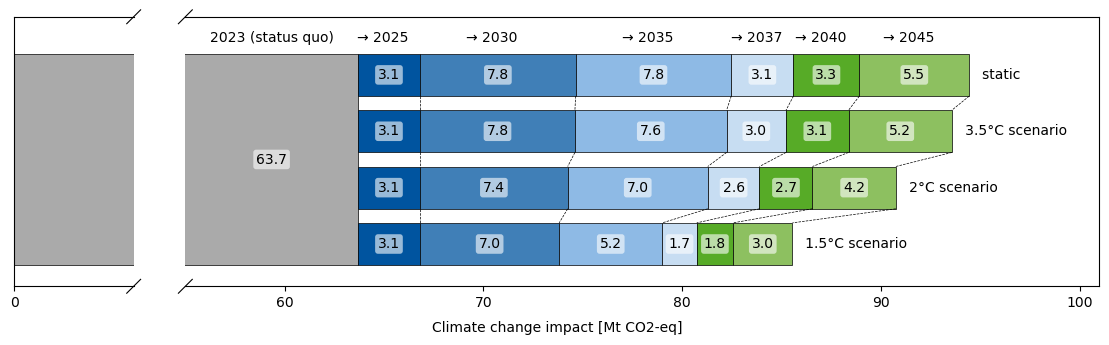

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from brokenaxes import brokenaxes

# Data
df_sankey = pd.read_csv("data/sankey_data.csv")
score_grid_status_quo = df_sankey[df_sankey["target"] == "grid status quo"][
    "value"
].sum()
data_base = {"Score": [score_grid_status_quo]}
df_base = pd.DataFrame(data_base)

data_static = {"Score": df_components["static"].sum().values / 1e9}
df_static = pd.DataFrame(data_static)

data_ssp2_base = {"Score": df_components["Base"].sum().values / 1e9}
df_ssp2_base = pd.DataFrame(data_ssp2_base)

data_rcp26 = {"Score": df_components["RCP26"].sum().values / 1e9}
df_rcp26 = pd.DataFrame(data_rcp26)

data_rcp19 = {"Score": df_components["RCP19"].sum().values / 1e9}
df_rcp19 = pd.DataFrame(data_rcp19)

# Figure and broken axes setup
fig = plt.figure(figsize=(14, 3.5))
fig.subplots_adjust(wspace=0.1)
bax = brokenaxes(xlims=((0, 6), (55, 101)), d=0.007, hspace=0.1, despine=False)
bax.set_ylim(-1.2, 1.35)

# Base bar settings
score_status_quo = sum(df_base["Score"])
base_bar_height = 2
addon_bar_height = 0.4

# Plot the base product score
left_extent = 0
midpoint_status_quo_right = 55 + (score_status_quo - 55) / 2
for score in df_base["Score"]:
    bax.barh(
        0,
        width=score,
        left=left_extent,
        height=base_bar_height,
        color="#aaaaaa",
        edgecolor="black",
        linewidth=0.5,
    )
    bax.text(
        midpoint_status_quo_right,
        1.15,
        "2023 (status quo)",
        ha="center",
        va="center",
        color="black",
    )
    left_extent += score

bbox_props = dict(boxstyle="round,pad=0.2", ec="none", fc="white", alpha=0.6)

bax.text(
    midpoint_status_quo_right,
    0,
    round(score_status_quo, 1),
    ha="center",
    va="center",
    color="black",
    bbox=bbox_props,
)


# Function to plot add-ons
def plot_addons(df, score_status_quo, y_position, bar_height, label, colors):
    total_width = score_status_quo
    for idx, score in enumerate(df["Score"]):
        bax.barh(
            y_position,
            width=score,
            left=score_status_quo,
            height=bar_height,
            color=colors[idx],
            edgecolor="black",
            linewidth=0.5,
        )
        bax.text(
            score_status_quo + score / 2,
            y_position,
            f"{round(score, 1)}",
            ha="center",
            va="center",
            color="black",
            bbox=bbox_props,
        )
        score_status_quo += score
        total_width += score
    bax.text(total_width, y_position, label, ha="left", va="center")


# Color settings
colors_addon = [
    cm.RWTHBlau.p(100),
    cm.RWTHBlau.p(75),
    cm.RWTHBlau.p(50),
    cm.RWTHBlau.p(25),
    cm.RWTHGruen.p(100),
    cm.RWTHGruen.p(75),
]

yshift_1 = 0.8
yshift_2 = 0.2666667

# Plot the static and prospective add-ons
plot_addons(
    df_static, score_status_quo, yshift_1, addon_bar_height, "   static", colors_addon
)
plot_addons(
    df_ssp2_base,
    score_status_quo,
    yshift_2,
    addon_bar_height,
    "   3.5°C scenario",
    colors_addon,
)
plot_addons(
    df_rcp26,
    score_status_quo,
    -yshift_2,
    addon_bar_height,
    "   2°C scenario",
    colors_addon,
)
plot_addons(
    df_rcp19,
    score_status_quo,
    -yshift_1,
    addon_bar_height,
    "   1.5°C scenario",
    colors_addon,
)


year_label_pos = score_status_quo
for val, yr in zip(
    df_static["Score"], ["→ 2025", "→ 2030", "→ 2035", "→ 2037", "→ 2040", "→ 2045"]
):
    bax.text(
        year_label_pos + val / 2 - 0.3,
        1.15,
        yr,
        ha="center",
        va="center",
        color="black",
    )
    year_label_pos += val

# connecting lines between the bars
x_static_counting = score_status_quo
x_base_counting = score_status_quo
x_rcp26_counting = score_status_quo
x_rcp19_counting = score_status_quo
for x_static, x_base, x_26, x_19 in zip(
    df_static.values, df_ssp2_base.values, df_rcp26.values, df_rcp19.values
):
    x_static_counting = x_static_counting + x_static

    x_base_counting = x_base_counting + x_base
    bax.plot(
        [x_static_counting, x_base_counting],
        [yshift_1 - addon_bar_height / 2, yshift_2 + addon_bar_height / 2],
        color="black",
        linewidth=0.5,
        linestyle="--",
    )

    x_rcp26_counting = x_rcp26_counting + x_26
    bax.plot(
        [x_base_counting, x_rcp26_counting],
        [yshift_2 - addon_bar_height / 2, -yshift_2 + addon_bar_height / 2],
        color="black",
        linewidth=0.5,
        linestyle="--",
    )

    x_rcp19_counting = x_rcp19_counting + x_19
    bax.plot(
        [x_rcp26_counting, x_rcp19_counting],
        [-yshift_2 - addon_bar_height / 2, -yshift_1 + addon_bar_height / 2],
        color="black",
        linewidth=0.5,
        linestyle="--",
    )


bax.set_xlabel("Climate change impact [Mt CO2-eq]", labelpad=25)
bax.axs[0].set_yticks([])
bax.axs[0].set_yticklabels([])

plt.savefig("figs/Fig4.svg", format="svg", bbox_inches="tight")
plt.show()

## GWI contributions on the component, material and process level (Figure 5)


### Components


In [40]:
components = pd.DataFrame(
    {
        "static": df_components["static"].T.sum().values,
        "Base": df_components["Base"].T.sum().values,
        "RCP26": df_components["RCP26"].T.sum().values,
        "RCP19": df_components["RCP19"].T.sum().values,
    },
    index=df_components.index,
)

component_groups = {
    "Overhead line": "overhead lines",
    "cable": "cables",
    "Transformer": "transformers",
    "switchgear": "switchgears",
    "Substation": "substations",
}


def map_labels(labels, groups, other_label="other"):
    new_labels = {}
    for label in labels:
        for key, group in groups.items():
            if key in label:
                new_labels[label] = group
                break
        else:
            new_labels[label] = other_label
    return new_labels


components.index = components.index.map(
    map_labels(components.index, component_groups, other_label="other components")
)
components = components.groupby(level=0).sum()

# sorting
components["sort_key"] = components.index != "other components"
components = components.sort_values(by=["sort_key", "static"], ascending=[True, True])
components = components.drop(columns="sort_key")

components.loc["SPACING"] = [
    0,
    components["static"].sum() - components["Base"].sum(),
    components["static"].sum() - components["RCP26"].sum(),
    components["static"].sum() - components["RCP19"].sum(),
]
components

,static,Base,RCP26,RCP19
substations,3.814100e+08,3.635553e+08,3.134279e+08,2.759815e+08
transformers,1.364650e+09,1.307536e+09,1.165226e+09,9.537986e+08
switchgears,2.494637e+09,2.487944e+09,2.467959e+09,2.427002e+09
overhead lines,1.302151e+10,1.263716e+10,1.136715e+10,9.147036e+09
cables,1.350520e+10,1.310008e+10,1.175839e+10,9.067497e+09
SPACING,0.000000e+00,8.711372e+08,3.695257e+09,8.896095e+09


### Materials


In [41]:
if recalculate:
    results_materials = {}
    bioflows = {}
    material_sums = {}

    for node in static_expansion_nodes + prospective_expansion_nodes:
        component_results = {}
        lca = bc.LCA({node: 1}, method=method)
        lca.lci(factorize=True)
        for component in node.technosphere():
            material_results = {}
            for material in list(component.input.technosphere()):
                lca.lcia(demand={material.input.id: material.amount * component.amount})
                material_results[material.input["name"]] = lca.score
            for bioflow in component.input.biosphere():
                bioflows[component.input["name"]] = bioflow
            component_results[component.input["name"]] = material_results

        results_materials[node["name"]] = component_results

    # Sum up materials
    for scenario, comp in results_materials.items():
        for component, materials in comp.items():
            for material, value in materials.items():
                if material not in material_sums:
                    material_sums[material] = {}
                if scenario not in material_sums[material]:
                    material_sums[material][scenario] = 0
                material_sums[material][scenario] += value

    with open("data/expansion_materials_results.json", "w") as f:
        json.dump(material_sums, f)

In [42]:
results_materials = json.load(open("data/expansion_materials_results.json"))
materials = pd.DataFrame.from_dict(results_materials, orient="index")

In [43]:
# Add SF6 leakage
distributed_components = json.load(open("data/distributed_components.json"))

sf6_row = {}

for col, year in zip(
    materials.columns,
    [
        2023,
        2025,
        2030,
        2035,
        2037,
        2040,
        2023,
        2025,
        2030,
        2035,
        2037,
        2040,
        2023,
        2025,
        2030,
        2035,
        2037,
        2040,
        2023,
        2025,
        2030,
        2035,
        2037,
        2040,
    ],
):
    sf6_impact = (
        distributed_components[str(year)]["gas_insulated_switchgear_420kv"]
        * 28.6
        * 25200
    )  # emissions and CF of sf6
    sf6_row[col] = sf6_impact

materials.loc["sulfur hexafluoride"] = sf6_row

In [44]:
material_groups = {
    "aluminium": "aluminium",
    "copper": "copper",
    "iron": "iron & steel",
    "steel": "iron & steel",
    "concrete": "concrete",
    "cement": "concrete",
    "sulfur hexafluoride": "SF6",
    "polyethylene": "plastics",
    "polypropylene": "plastics",
    "plastic": "plastics",
}

materials.index = materials.index.map(
    map_labels(materials.index, material_groups, other_label="other materials")
)
materials = materials.groupby(level=0).sum()

materials.columns = pd.MultiIndex.from_tuples(
    [(col.split("_", 2)[1], col.rsplit("_", 1)[1]) for col in materials.columns]
)

materials = pd.DataFrame(
    {
        "static": materials["static"].T.sum().values,
        "Base": materials["Base"].T.sum().values,
        "RCP26": materials["RCP26"].T.sum().values,
        "RCP19": materials["RCP19"].T.sum().values,
    },
    index=materials.index,
)

# sorting
materials["sort_key"] = materials.index != "other materials"
materials = materials.sort_values(by=["sort_key", "static"], ascending=[True, True])
materials = materials.drop(columns="sort_key")

materials.loc["SPACING"] = [
    0,
    materials["static"].sum() - materials["Base"].sum(),
    materials["static"].sum() - materials["RCP26"].sum(),
    materials["static"].sum() - materials["RCP19"].sum(),
]
materials

,static,Base,RCP26,RCP19
other materials,1.640372e+09,1.601614e+09,1.500779e+09,1.330792e+09
concrete,1.261635e+09,1.245235e+09,1.075385e+09,9.945494e+08
plastics,2.138492e+09,2.100820e+09,1.984358e+09,1.685277e+09
SF6,2.302660e+09,2.301923e+09,2.300104e+09,2.298658e+09
copper,5.024421e+09,4.843711e+09,4.135848e+09,3.135350e+09
iron & steel,5.477935e+09,5.237239e+09,4.594727e+09,4.047973e+09
aluminium,1.292190e+10,1.256573e+10,1.148095e+10,8.378717e+09
SPACING,0.000000e+00,8.711372e+08,3.695257e+09,8.896095e+09


### Processes


In [45]:
import bw2analyzer as ba

if recalculate:
    process_results = {}
    product_impacts_static = {}
    product_impacts_base = {}
    product_impacts_rcp26 = {}
    product_impacts_rcp19 = {}

    lca = bc.LCA(
        {static_expansion_nodes[0]: 1}, method=method
    )  # just to build the matrices
    lca.lci(factorize=True)
    for node in static_expansion_nodes:
        lca.lcia(demand={node.id: 1})
        top_processes = ba.ContributionAnalysis().annotated_top_processes(
            lca, limit=1000
        )
        for process in top_processes:
            if process[2]["reference product"] in product_impacts_static:
                product_impacts_static[process[2]["reference product"]] += process[0]
            else:
                product_impacts_static[process[2]["reference product"]] = process[0]
    process_results["static"] = product_impacts_static

    for node in prospective_expansion_nodes_base:
        lca = bc.LCA({node: 1}, method=method)
        lca.lci()
        lca.lcia()
        top_processes = ba.ContributionAnalysis().annotated_top_processes(
            lca, limit=1000
        )
        for process in top_processes:
            if process[2]["reference product"] in product_impacts_base:
                product_impacts_base[process[2]["reference product"]] += process[0]
            else:
                product_impacts_base[process[2]["reference product"]] = process[0]
    process_results["Base"] = product_impacts_base

    for node in prospective_expansion_nodes_rcp26:
        lca = bc.LCA({node: 1}, method=method)
        lca.lci()
        lca.lcia()
        top_processes = ba.ContributionAnalysis().annotated_top_processes(
            lca, limit=1000
        )
        for process in top_processes:
            if process[2]["reference product"] in product_impacts_rcp26:
                product_impacts_rcp26[process[2]["reference product"]] += process[0]
            else:
                product_impacts_rcp26[process[2]["reference product"]] = process[0]
    process_results["RCP26"] = product_impacts_rcp26

    for node in prospective_expansion_nodes_rcp19:
        lca = bc.LCA({node: 1}, method=method)
        lca.lci()
        lca.lcia()
        top_processes = ba.ContributionAnalysis().annotated_top_processes(
            lca, limit=1000
        )
        for process in top_processes:
            if process[2]["reference product"] in product_impacts_rcp19:
                product_impacts_rcp19[process[2]["reference product"]] += process[0]
            else:
                product_impacts_rcp19[process[2]["reference product"]] = process[0]
    process_results["RCP19"] = product_impacts_rcp19

    with open("data/expansion_process_results.json", "w") as f:
        json.dump(process_results, f)

In [46]:
process_results = json.load(open("data/expansion_process_results.json"))
processes = pd.DataFrame(process_results)

product_groups = {
    "electricity": "electricity",
    "heat": "heat",
    "transport": "transport",
    "aluminium": "aluminium (process emissions)",
    "iron": "iron & steel (process emissions)",
    "steel": "iron & steel (process emissions)",
    "coal": "coal",
    "coke": "coal",
    "clinker": "clinker",
    "diesel": "transport",
    "Gas insulated switchgear": "SF6",
    "sulfur hexafluoride": "SF6",
}

processes.index = processes.index.map(
    map_labels(processes.index, product_groups, other_label="other processes")
)

processes = processes.groupby(level=0).sum()

# sorting
processes["sort_key"] = processes.index != "other processes"
processes = processes.sort_values(by=["sort_key", "static"], ascending=[True, True])
processes = processes.drop(columns="sort_key")

processes.loc["SPACING"] = [
    0,
    processes["static"].sum() - processes["Base"].sum(),
    processes["static"].sum() - processes["RCP26"].sum(),
    processes["static"].sum() - processes["RCP19"].sum(),
]
processes

,static,Base,RCP26,RCP19
other processes,3.467266e+09,3.413861e+09,3.401665e+09,3.415660e+09
clinker,9.845274e+08,9.814810e+08,7.399148e+08,7.282934e+08
aluminium (process emissions),1.659360e+09,1.659771e+09,1.659778e+09,1.660076e+09
transport,1.716158e+09,1.689090e+09,1.652182e+09,1.573991e+09
SF6,2.295328e+09,2.295329e+09,2.295330e+09,2.295332e+09
coal,2.580012e+09,2.489900e+09,2.224287e+09,1.605565e+09
iron & steel (process emissions),2.844062e+09,2.696450e+09,2.361009e+09,2.057190e+09
heat,3.515677e+09,3.509251e+09,3.517160e+09,3.543474e+09
electricity,1.159214e+10,1.104261e+10,9.096151e+09,4.881194e+09
SPACING,0.000000e+00,8.767891e+08,3.707052e+09,8.893752e+09


### Plotting


In [47]:
def round_to_percentages(df):
    def adjust_to_100(absolute_values):
        total = absolute_values.sum()
        percentages = (absolute_values / total * 100).round()
        difference = 100 - percentages.sum()
        if difference != 0:
            idx = absolute_values.index[
                absolute_values.index.str.contains("other")
            ].tolist()
            if not idx:  # If no "other" index, use the largest decimal part
                idx = (absolute_values / total * 100 - percentages).abs().idxmax()
            else:
                idx = idx[0]
            percentages.at[idx] += difference

        return percentages

    rounded_df = df.apply(adjust_to_100, axis=0).astype(int)
    assert (
        rounded_df.sum() == np.array([100, 100, 100, 100])
    ).all()  # check rounding errors
    return rounded_df

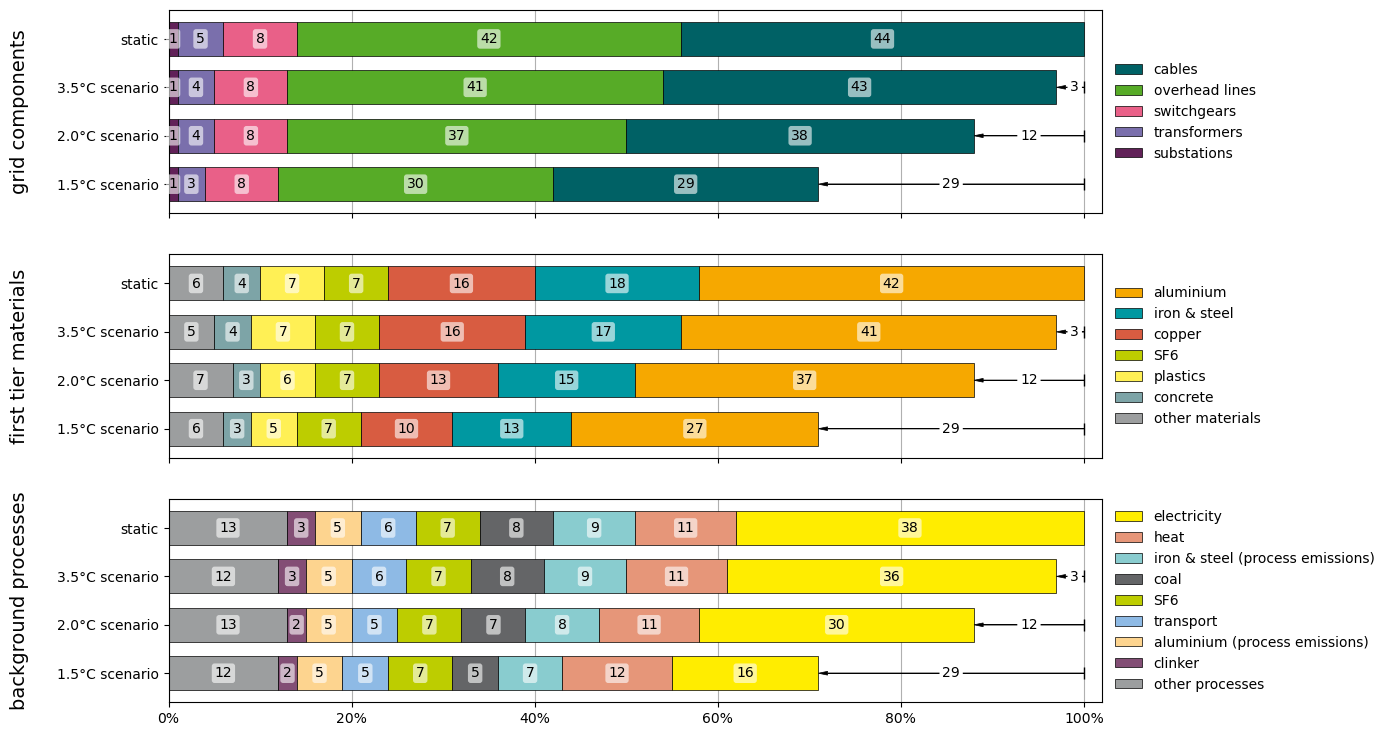

In [48]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.style.use("rwth")

components_plot = round_to_percentages(components)
materials_plot = round_to_percentages(materials)
processes_plot = round_to_percentages(processes)

scenario_label_mapping = {
    "Base": "3.5°C scenario",
    "RCP26": "2.0°C scenario",
    "RCP19": "1.5°C scenario",
}
for df in [components_plot, materials_plot, processes_plot]:
    df.columns = df.columns.map(lambda x: scenario_label_mapping.get(x, x))


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 7.5), sharex=True)
plt.subplots_adjust(hspace=0.6)

general_plot_kwargs = dict(
    kind="barh",
    stacked=True,
    width=0.7,
    edgecolor="black",
    linewidth=0.5,
)
component_colors = ["none"] + plot_colors_components
components_plot.T.plot(ax=axes[0], color=component_colors[::-1], **general_plot_kwargs)

material_colors = ["none"] + plot_colors_materials
materials_plot.T.plot(ax=axes[1], color=material_colors[::-1], **general_plot_kwargs)

process_colors = ["none"] + plot_colors_processes
processes_plot.T.plot(ax=axes[2], color=process_colors[::-1], **general_plot_kwargs)

axes[0].set_ylabel("grid components", fontsize=14, labelpad=20)
axes[1].set_ylabel("first tier materials", fontsize=14, labelpad=20)
axes[2].set_ylabel("background processes", fontsize=14, labelpad=20)

for idx, (ax, data) in enumerate(
    zip(axes, [components_plot, materials_plot, processes_plot])
):
    ax.invert_yaxis()
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*[(h, l) for h, l in zip(handles, labels) if l != "SPACING"])
    ax.legend(
        handles[::-1],
        labels[::-1],
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        frameon=False,
    )

    ax.xaxis.grid(True)
    ax.set_axisbelow(True)

    totals = data.sum(axis=1)

    # Adding percentage labels to each bar
    for bar in ax.patches:
        label_x_pos = bar.get_x() + bar.get_width() / 2 
        label_y_pos = bar.get_y() + bar.get_height() / 2
        total_width = sum(
            [p.get_width() for p in ax.patches if p.get_y() == bar.get_y()]
        )  # Sum width of all bars in this row
        percentage = bar.get_width()
        percentage_text = f"{round(percentage)}"
        if percentage > 0:
            rotation = 0
            fontsize = 10
            bbox_props = dict(
                boxstyle="round,pad=0.2", ec="none", fc="white", alpha=0.6
            )
            if bar in ax.patches[-4:]:
                bbox_props = dict(
                    boxstyle="round,pad=0.2", ec="none", fc="white", alpha=1
                )
                if percentage < 5:
                    label_x_pos = label_x_pos + 0.5

            ax.text(
                label_x_pos,
                label_y_pos,
                percentage_text,
                ha="center",
                va="center",
                rotation=rotation,
                fontsize=fontsize,
                bbox=bbox_props,
            )

    # arrows from right end of bars
    for bar in ax.patches[-3:]:
        bar.set_edgecolor("none")

        x_end = bar.get_x() + bar.get_width() 
        y_position = (
            bar.get_y() + bar.get_height() / 2
        )

        head_width = bar.get_height() / 9
        head_length = 1
        ax.arrow(
            x_end,
            y_position,
            -bar.get_width() + head_length,
            0,
            head_width=head_width,
            head_length=head_length,
            width=0.01,
            fc="black",
            ec="black",
            lw=0.5,
        )
        ax.plot(x_end, y_position, marker="|", color="black", markersize=8)

axes[-1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}%"))

for ax in axes:
    ax.set_xlim(0, 102)

plt.tight_layout(h_pad=0.5)

plt.savefig("figs/Fig5.svg", format="svg", bbox_inches="tight")
plt.show()

## All impact categories (Figure 6)

In [49]:
if recalculate:
    functional_units = {
        "static": {act.id: 1 for act in static_expansion_nodes},
        "Base": {act.id: 1 for act in prospective_expansion_nodes_base},
        "RCP26": {act.id: 1 for act in prospective_expansion_nodes_rcp26},
        "RCP19": {act.id: 1 for act in prospective_expansion_nodes_rcp19},
    }

    chosen_methods = [m for m in bd.methods if "EF v3.1 no LT" in m[0]]

    mlca_config = {
        "impact_categories": chosen_methods,
    }

    data_objs = bd.get_multilca_data_objs(
        functional_units=functional_units, method_config=mlca_config
    )

    mlca = bc.MultiLCA(
        demands=functional_units, method_config=mlca_config, data_objs=data_objs
    )
    mlca.lci()
    mlca.lcia()

    df = pd.DataFrame(mlca.scores.items(), columns=["MethodProcess", "Score"])
    df[["Method", "Process"]] = pd.DataFrame(
        df["MethodProcess"].tolist(), index=df.index
    )

    df_mlca = df.pivot(index="Process", columns="Method", values="Score")

    def extract_ia_name(method_tuple):
        return method_tuple[1][:-6]  # remove "no LT" from the method name

    df_mlca.columns = df_mlca.columns.map(extract_ia_name)

    json.dump(df_mlca.to_dict(), open("data/expansion_all_impact_categories.json", "w"))

In [50]:
df_mlca = pd.DataFrame(json.load(open("data/expansion_all_impact_categories.json")))

df_mlca = df_mlca[
    [
        "acidification",
        "climate change",
        "ecotoxicity: freshwater",
        "energy resources: non-renewable",
        "eutrophication: freshwater",
        "eutrophication: marine",
        "eutrophication: terrestrial",
        "human toxicity: carcinogenic",
        "human toxicity: non-carcinogenic",
        "ionising radiation: human health",
        "land use",
        "material resources: metals/minerals",
        "ozone depletion",
        "particulate matter formation",
        "photochemical oxidant formation: human health",
        "water use",
    ]
]

Normalize with respect to the static results:


In [51]:
df_mlca.loc["Base"] = df_mlca.loc["Base"] / df_mlca.loc["static"]
df_mlca.loc["RCP26"] = df_mlca.loc["RCP26"] / df_mlca.loc["static"]
df_mlca.loc["RCP19"] = df_mlca.loc["RCP19"] / df_mlca.loc["static"]
df_mlca.loc["static"] = 1

Plot:

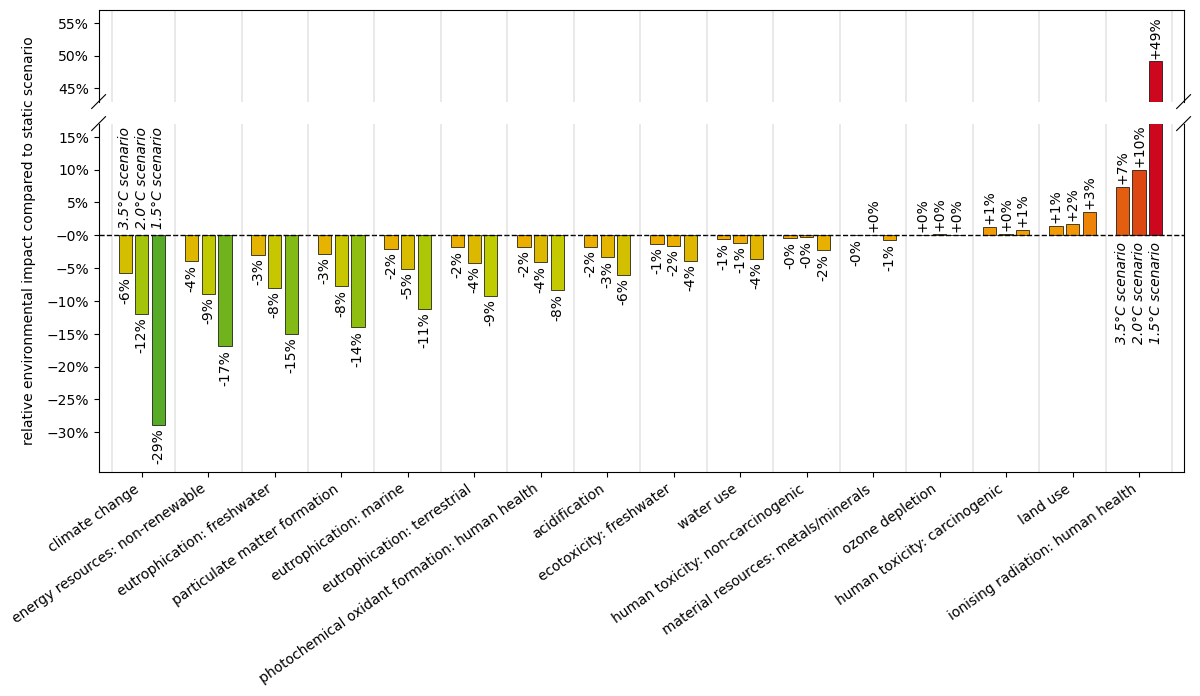

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.ticker import PercentFormatter
from brokenaxes import brokenaxes

values_base = df_mlca.loc["Base"].sort_values(ascending=True)
values_r26 = df_mlca.loc["RCP26"].sort_values(ascending=True)
values_r19 = df_mlca.loc["RCP19"].sort_values(ascending=True)

bordeaux = cm.RWTHBordeaux.p(100)
red = cm.RWTHRot.p(100)
orange = cm.RWTHOrange.p(100)
yellow = cm.RWTHGelb.p(100)
maigreen = cm.RWTHMaiGruen.p(100)
green = cm.RWTHGruen.p(100)

cmap = LinearSegmentedColormap.from_list(
    "custom_red_green", [green, green, maigreen, orange, red, red, red]
)


# Normalizing with midpoint adjustment class
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint
        x, y = [vmin, midpoint, vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(result, x, y))


# Compute shifts to center around 0
shifted_base = values_base - 1
shifted_r26 = values_r26 - 1
shifted_r19 = values_r19 - 1

# Concatenate all values for normalization
all_values = np.concatenate([shifted_r26, shifted_r19, shifted_base])
norm = MidpointNormalize(vmin=all_values.min(), vmax=all_values.max(), midpoint=0)

fig = plt.figure(figsize=(14, 6))
bax = brokenaxes(
    ylims=((-0.36, 0.17), (0.43, 0.57)), d=0.007, hspace=0.1, despine=False
)
bax.set_xlim(-1, 39.8)
index = np.arange(len(values_r26)) * 2.5
bar_height = 0.5

bars_base = bax.bar(
    index,
    shifted_base,
    bar_height,
    color=cmap(norm(shifted_base.values)),
    edgecolor="black",
    linewidth=0.5,
)
bars_r19 = bax.bar(
    index + 2.5 * bar_height,
    shifted_r19,
    bar_height,
    color=cmap(norm(shifted_r19.values)),
    edgecolor="black",
    linewidth=0.5,
)
bars_r26 = bax.bar(
    index + 1.25 * bar_height,
    shifted_r26,
    bar_height,
    color=cmap(norm(shifted_r26.values)),
    edgecolor="black",
    linewidth=0.5,
)

bax.set_ylabel("relative environmental impact compared to static scenario", labelpad=45)

bax.axs[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
bax.axs[1].set_yticks(np.arange(-0.3, 0.2, 0.05))
bax.axs[1].set_xticks(index + 1.25 * bar_height)
bax.axs[1].set_xticklabels(labels=values_r26.index, rotation=35, ha="right")

bax.axs[0].set_yticks(np.arange(0.45, 0.55, 0.05))

datasets = [shifted_r26, shifted_r19, shifted_base]
bar_positions = [index + 1.25 * bar_height, index + 2.5 * bar_height, index]

for dataset, bars, position, scenario_label in zip(
    datasets,
    [bars_r26, bars_r19, bars_base],
    bar_positions,
    ["2.0°C scenario", "1.5°C scenario", "3.5°C scenario"],
):
    for idx, height in enumerate(dataset):
        percentage_change = height * 100
        sign = "+" if percentage_change > 0 else ""
        text = f"{sign}{percentage_change:.0f}%"
        bax.text(
            position[idx],
            height + 0.005 if height > 0 else height - 0.005,
            text,
            ha="center",
            va="bottom" if height > 0 else "top",
            rotation=90,
        )
        if idx == 0 or idx == len(dataset) - 1:
            bax.text(
                position[idx],
                -0.01 if height > 0 else 0.01,
                scenario_label,
                ha="center",
                va="top" if height > 0 else "bottom",
                rotation=90,
                style="italic",
            )

for ax in bax.axs:
    ax.axvline(x=-0.5, color="grey", linestyle="-", linewidth=0.25)
    for x_pos in index + 3.75 * bar_height:
        ax.axvline(x=x_pos, color="grey", linestyle="-", linewidth=0.25)
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

plt.savefig("figs/Fig6.svg", format="svg", bbox_inches="tight")
plt.show()

## Grid-related Climate Change Impact per kWh Electricity

### Electricity generation impacts


In [53]:
scores = {}
for act in bd.Database("new_mixes"):
    lca = bc.LCA({act: 1}, method=method)
    lca.lci()
    lca.lcia()
    scores[act["name"]] = lca.score

/Users/timodiepers/anaconda3/envs/plca-grid-expansion/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.31e+13)
  warnings.warn(msg, UmfpackWarning)


In [54]:
scenario_mapping = {
    "market for electricity, low voltage DE 2023 NO GRID": "statusquo",
    "market for electricity, low voltage DE 2045 RCP19 NO GRID": "SS2_rcp19",
    "market for electricity, low voltage DE 2045 RCP26 NO GRID": "SS2_rcp26",
    "market for electricity, low voltage DE 2045 Base NO GRID": "SS2_base",
}

In [56]:
electricity_generation_impacts = {
    scenario_mapping[key]: val for key, val in scores.items()
}

electricity_generation_impacts["static_expansion"] = electricity_generation_impacts[
    "statusquo"
]

electricity_generation_impacts  # kg CO2-eq per kWh

{'SS2_rcp19': 0.04904727645596258,
 'SS2_rcp26': 0.07303488832703958,
 'statusquo': 0.38763190425984223,
 'SS2_base': 0.4720193005793143,
 'static_expansion': 0.38763190425984223}

### Grid related impacts per kWh consumed


In [57]:
CONSUMPTION_2023 = 474.2  # TWh/a, Source: https://www.bundesnetzagentur.de/SharedDocs/Pressemitteilungen/DE/2023/20230104_smard.html
CONSUMPTION_2045 = 801.4  # TWh/a, Source: https://www.netzentwicklungsplan.de/sites/default/files/2023-12/NEP%20kompakt_2037_2045_V2023_2E.pdf
LIFETIME = 30  # years

In [58]:
score_static = df_static.sum().sum()
score_base = df_ssp2_base.sum().sum()
score_rcp26 = df_rcp26.sum().sum()
score_rcp19 = df_rcp19.sum().sum()

grid_impacts_per_kwh = {
    "statusquo": score_status_quo / LIFETIME / CONSUMPTION_2023,
    "static_expansion": (score_status_quo + score_static)
    / LIFETIME
    / CONSUMPTION_2045,  # score is in Mt co2-eq, consumption in TWh/a, so units cancel out to kg co2-eq
    "SS2_base": (score_status_quo + score_base) / LIFETIME / CONSUMPTION_2045,
    "SS2_rcp26": (score_status_quo + score_rcp26) / LIFETIME / CONSUMPTION_2045,
    "SS2_rcp19": (score_status_quo + score_rcp19) / LIFETIME / CONSUMPTION_2045,
}

grid_impacts_per_kwh

{'statusquo': 0.004476417861884732,
 'static_expansion': 0.003928497251252433,
 'SS2_base': 0.003892263277478795,
 'SS2_rcp26': 0.003774797175114826,
 'SS2_rcp19': 0.003558474158329787}

### Totals and share of grid


In [59]:
total_impacts_per_kwh = {
    key: electricity_generation_impacts[key] + grid_impacts_per_kwh[key]
    for key in set(electricity_generation_impacts | grid_impacts_per_kwh)
}

total_impacts_per_kwh

{'static_expansion': 0.39156040151109467,
 'statusquo': 0.39210832212172697,
 'SS2_rcp19': 0.05260575061429237,
 'SS2_base': 0.47591156385679306,
 'SS2_rcp26': 0.0768096855021544}

In [60]:
percentage_of_grid = {
    key: grid_impacts_per_kwh[key] / electricity_generation_impacts[key] * 100
    for key in set(electricity_generation_impacts | grid_impacts_per_kwh)
}

percentage_of_grid

{'static_expansion': 1.013460762151052,
 'statusquo': 1.1548115138851016,
 'SS2_rcp19': 7.255192164492123,
 'SS2_base': 0.824598331615207,
 'SS2_rcp26': 5.168484900273736}